In [1]:
import jax.numpy as jnp
import numpy as onp
import matplotlib.pyplot as plt

from jax.config import config
config.update("jax_enable_x64", True)
from jax import jit

from jax_cosmo import Planck15
from jax_cosmo import probes
from jax_cosmo import Cosmology
from jax_cosmo.angular_cl import gaussian_cl_covariance_and_mean
from jax_cosmo.bias import constant_linear_bias
from jax_cosmo.redshift import smail_nz

from jax import jacfwd, jacrev

from modified_likelihood import marginalised_log_likelihood
from modified_likelihood import gaussian_log_likelihood

In [2]:
import emcee
from numpy.testing import assert_array_equal
from numpy.testing import assert_allclose

In [3]:
from jax.scipy.special import logsumexp

### Useful Functions

In [4]:
def get_cosmo_params(cosmo): 
    
    return jnp.array([cosmo.sigma8, cosmo.Omega_c, cosmo.Omega_b, cosmo.h, cosmo.n_s, cosmo.w0])

In [5]:
def cosmo_params_to_obj(params):
    
    cosmo = Cosmology(sigma8=params[0], Omega_c=params[1], 
                      Omega_b=params[2], h=params[3], n_s=params[4], 
                      w0=params[5], Omega_k=0., wa=0.)
    
    return cosmo

In [6]:
def plot_lhood(likelihood):
    param_space = jnp.arange(0.6, 1.2, 0.05)
    f = []
    for p in param_space:
            f.append(likelihood(p))
            
    plt.plot(param_space, f)
    
    return f
    

In [7]:
def sample(nwalkers, ndim, logp, nruns=10):
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logp)
    
    #random nos between 0 and 1
    p0 = onp.random.rand(nwalkers, ndim)
    
    #remove burn-in
    state = sampler.run_mcmc(p0, 100)
    sampler.reset()
    
    #
    for n in range(nruns):
        state = sampler.run_mcmc(state, 100)
        
    return sampler.get_chain(flat=True)
    

### Theory Vector

In [8]:
@jit
def cl(sig8, z0):
    """function to calculate a test cl"""
    
    n_ell = 5
    ell = jnp.logspace(1, 3, n_ell)
    
    nz = [smail_nz(1.0, 2.0, z0)]
    bias = constant_linear_bias(1.0)
    p = [probes.NumberCounts(nz, bias)]
    
    planck_params = get_cosmo_params(Planck15())
    planck_params = planck_params.at[0].set(sig8)
    cosmo = cosmo_params_to_obj(planck_params)
    
    mu, cov = gaussian_cl_covariance_and_mean(cosmo, ell, p, sparse=False)
    
    return mu, cov

### Generate Data

In [9]:
fid_z0 = 1.0
fid_sigma = Planck15().sigma8

In [10]:
clandcov = cl(fid_sigma, fid_z0)

data, C = clandcov[0], clandcov[1]

In [11]:
jacobian = jit(jacfwd(cl, argnums=1))

mean = onp.array([fid_z0])
P = jnp.array([[0.05]])

jac_at_fid = jacobian(fid_sigma, fid_z0)[0]
T = jnp.reshape(jac_at_fid, (jac_at_fid.shape[0], len(P))) #reshape need for 1d

nz_mean = jnp.array([1.0])

In [12]:
#gaussian likelihood
lhood = lambda s : gaussian_log_likelihood(data, cl(s, fid_z0)[0], C, include_logdet=False, inverse_method="inverse")

#analytically marginalised likelihood
lhood_analytical = lambda s : marginalised_log_likelihood(data, cl(s, mean[0])[0], C, P, T)


#numerical lhoods
#nz likelihood
lhood_nz = lambda s: gaussian_log_likelihood(nz_mean, jnp.array([s]), P, include_logdet=False, inverse_method="inverse")
lhood_cl = lambda s, z : gaussian_log_likelihood(data, cl(s, z)[0], C, include_logdet=False, inverse_method="inverse") 

In [13]:
def gauss_posterior(p):
    sig8 = p[0]
    if(sig8<0 or sig8>1.1):
        return -onp.inf
    else:
        return lhood(sig8)

In [14]:
def analytical_posterior(p):
    sig8 = p[0]
    if(sig8<0 or sig8>1.1):
        return -onp.inf
    else:
        return lhood_analytical(sig8)

(array([  1.,   1.,   0.,   0.,   1.,   3.,   4.,   3.,   5.,   3.,   7.,
          8.,   9.,  12.,  27.,  23.,  33.,  37.,  36.,  46.,  79.,  61.,
         92., 116., 104., 152., 154., 194., 239., 255., 280., 303., 351.,
        377., 395., 435., 480., 545., 551., 576., 616., 687., 671., 704.,
        660., 675., 718., 676., 655., 675., 626., 592., 605., 557., 528.,
        505., 452., 401., 360., 352., 322., 286., 257., 212., 188., 164.,
        157., 143.,  90.,  94.,  79.,  48.,  47.,  41.,  36.,  23.,  21.,
         13.,  13.,  13.,  13.,   7.,   6.,   2.,   3.,   1.,   2.,   2.,
          0.,   0.,   2.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.8022661 , 0.80656491, 0.81086373, 0.81516254, 0.81946135,
        0.82376016, 0.82805897, 0.83235779, 0.8366566 , 0.84095541,
        0.84525422, 0.84955304, 0.85385185, 0.85815066, 0.86244947,
        0.86674828, 0.8710471 , 0.87534591, 0.87964472, 0.88394353,
        0.88824235, 0.89254116, 0.89683997, 0.

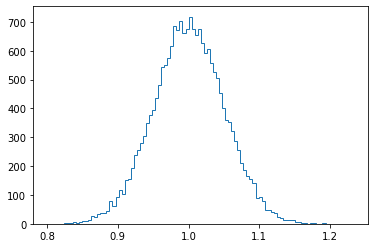

In [15]:
plt.hist(onp.random.normal(1.0, 0.05, 20000).flatten(), 100, histtype="step")

In [16]:
@jit
def log_sum_exp(sigma8):
        z0grid = onp.arange(0.8, 1.2, 0.005)
        arg = jnp.ones(len(z0grid))
        
        j = 0
        for i in z0grid:
            arg = arg.at[j].set(lhood_nz(i) + lhood_cl(sigma8, i))
            j+=1
            
        return logsumexp(arg)

In [17]:
#compile
log_sum_exp(fid_sigma)

DeviceArray(0.44291568, dtype=float64)

In [18]:
def numerical_posterior(p):
    sig8 = p[0]
    if(sig8<0 or sig8>1.1):
        return -onp.inf
    else:        
        return log_sum_exp(sig8)

# Tests

In [19]:
nwalkers = 5
ndim=1

In [20]:
gauss_samples = sample(nwalkers, ndim, gauss_posterior, nruns=10)

In [21]:
analytical_samples = sample(nwalkers, ndim, analytical_posterior, nruns=10)

In [22]:
numerical_samples = sample(nwalkers, ndim, numerical_posterior, nruns=10)

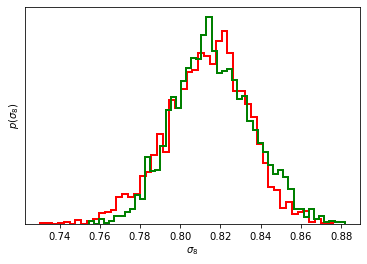

In [26]:
#plt.hist(gauss_samples[:, 0], 100, color="k", histtype="step", density=True)
plt.hist(analytical_samples[:, 0], 50, color="r", histtype="step", density=True, lw=2)
plt.hist(numerical_samples[:, 0], 50, color="g", histtype="step", density=True, lw=2)
plt.xlabel(r"$\sigma_8$")
plt.ylabel(r"$p(\sigma_8)$")
plt.gca().set_yticks([]);